### Defences for differential privacy and federated learning

This notebook implements *true differentially private stochastic gradient descent* (DP-SGD) in a federated setting and evaluates privacy via membership inference AUC and utility via test accuracy.

True DP-SGD was formalized by [Abadi et al.](https://arxiv.org/pdf/2102.03013) as a way to train neural nets with DP guarantees by combining three steps on each mini-batch of data:
* Pre-sample gradient computation
* Clipping gradients so L2 norm is less than the clip norm. This ensures no single sample can dominate the update
* Noise addition: adding a Gaussian noise to the sum of clipped gradients, for which we will see the mathematical notation below: σ * C

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')


DIFFERENTIAL PRIVACY DEFENSES FOR FEDERATED LEARNING — FIXED
This notebook implements true DP-SGD in a federated setting and evaluates
privacy via membership inference AUC and utility via test accuracy.


In [2]:
# DP-SGD utilities 

def _per_sample_grads(model, loss_per_sample):
    """Compute per-sample gradients by looping each example (fine for small N)."""
    params = [p for p in model.parameters() if p.requires_grad]
    B = loss_per_sample.shape[0]
    grad_samples = [torch.zeros((B, *p.shape), device=loss_per_sample.device, dtype=p.dtype)
                    for p in params]
    for i in range(B):
        model.zero_grad(set_to_none=True)
        loss_per_sample[i].backward(retain_graph=True)
        for j, p in enumerate(params):
            grad_samples[j][i] = p.grad.detach().clone()
    return grad_samples

def _clip_and_aggregate(grad_samples, C, sigma):
    """Clip per-sample gradients by L2 norm C and add Gaussian noise (sigma*C)."""
    B = grad_samples[0].shape[0]
    with torch.no_grad():
        norms_sq = None
        for g in grad_samples:
            g_flat = g.view(B, -1)
            norms_sq = (g_flat**2).sum(dim=1) if norms_sq is None else norms_sq + (g_flat**2).sum(dim=1)
        norms = norms_sq.sqrt() + 1e-12
        factors = (C / norms).clamp(max=1.0)  # [B]
    agg = []
    for g in grad_samples:
        view_shape = (B,) + (1,) * (g.dim() - 1)
        clipped = g * factors.view(view_shape)
        summed = clipped.sum(dim=0)
        noise = torch.normal(0.0, sigma * C, size=summed.shape, device=summed.device, dtype=summed.dtype)
        agg.append((summed + noise) / B)  # average
    return agg

def dp_sgd_step(model, optimizer, X, y, C=1.0, sigma=1.0):
    logits = model(X)
    loss_vec = F.cross_entropy(logits, y, reduction='none')
    grad_samples = _per_sample_grads(model, loss_vec)
    agg_grads = _clip_and_aggregate(grad_samples, C=C, sigma=sigma)
    optimizer.zero_grad(set_to_none=True)
    for p, g in zip([p for p in model.parameters() if p.requires_grad], agg_grads):
        p.grad = g
    optimizer.step()
    return loss_vec.mean().item()

def approximate_epsilon(sampling_rate, steps, sigma, delta=1e-5):
    """Approximate epsilon for DP-SGD (Abadi-style bound; good for demo)."""
    import math
    q = sampling_rate
    c2 = 2 * math.log(1.25 / max(delta, 1e-12))
    eps = q * math.sqrt(steps * c2) / sigma + steps * (q**2) / (sigma**2)
    return float(eps)


In [4]:
# Synethetic data creation 

def create_medical_dataset(n_patients=300):
    np.random.seed(42)
    ages = np.random.normal(55, 15, n_patients).clip(20, 90)
    cholesterol = 150 + 2 * ages + np.random.normal(0, 30, n_patients)
    cholesterol = cholesterol.clip(120, 350)
    systolic_bp = 90 + 0.8 * ages + 0.1 * cholesterol + np.random.normal(0, 15, n_patients)
    systolic_bp = systolic_bp.clip(90, 200)
    heart_rate = 85 - 0.2 * ages + np.random.normal(0, 10, n_patients)
    heart_rate = heart_rate.clip(50, 120)
    exercise_hours = np.maximum(0, 8 - 0.05 * ages + np.random.normal(0, 3, n_patients))
    bmi = 22 + 0.1 * ages - 0.3 * exercise_hours + np.random.normal(0, 4, n_patients)
    bmi = bmi.clip(16, 45)
    X = np.column_stack([ages, cholesterol, systolic_bp, heart_rate, exercise_hours, bmi])
    risk_score = (
        0.03*ages + 0.01*cholesterol + 0.02*systolic_bp - 0.05*exercise_hours + 0.1*bmi
        + np.random.normal(0, 2, n_patients)
    )
    y = (risk_score > np.percentile(risk_score, 70)).astype(int)
    feature_names = ['Age', 'Cholesterol', 'Systolic_BP', 'Heart_Rate', 'Exercise_Hours', 'BMI']
    return X, y, feature_names

def create_hospital_data():
    X, y, feature_names = create_medical_dataset()
    hospital_a_indices = np.where((X[:, 0] < 50) | (X[:, 4] > 5))[0][:80]
    hospital_b_indices = np.where((X[:, 0] >= 40) & (X[:, 0] <= 65))[0][:90]
    hospital_c_indices = np.where((X[:, 0] > 55) | (X[:, 2] > 140))[0][:80]
    used_indices = set()
    hospitals_data = []
    hospital_names = ["Edinburgh Hospital", "Clydebank Infirmary", "Orkney Hospital"]
    for i, indices in enumerate([hospital_a_indices, hospital_b_indices, hospital_c_indices]):
        available = [idx for idx in indices if idx not in used_indices][:70 + i*10]
        used_indices.update(available)
        hospitals_data.append((X[available], y[available], hospital_names[i]))
    return hospitals_data, feature_names

# Build datasets and scaler
hospitals_data, feature_names = create_hospital_data()
scaler = StandardScaler()
all_data = np.vstack([X for (X, y, name) in hospitals_data])
scaler.fit(all_data)

print("Hospital splits:")
for Xh, yh, nm in hospitals_data:
    print(f"  {nm}: {len(Xh)} patients, disease rate {yh.mean()*100:.1f}%")

# Build a holdout test set EARLY (used by multiple sections)
def build_holdout(all_data, scaler):
    excluded = set().union(
        set(np.where((all_data[:, 0] < 50) | (all_data[:, 4] > 5))[0][:80]),
        set(np.where((all_data[:, 0] >= 40) & (all_data[:, 0] <= 65))[0][:90]),
        set(np.where((all_data[:, 0] > 55) | (all_data[:, 2] > 140))[0][:80]),
    )
    test_indices = list(set(range(len(all_data))) - excluded)[:50]
    X = scaler.transform(all_data[test_indices])
    risk = (
        0.03 * all_data[test_indices, 0] +
        0.01 * all_data[test_indices, 1] +
        0.02 * all_data[test_indices, 2] -
        0.05 * all_data[test_indices, 4] +
        0.10 * all_data[test_indices, 5]
    )
    y = (risk > np.percentile(risk, 70)).astype(int)
    return X, y

test_X, test_y = build_holdout(all_data, scaler)
print(f"Holdout built: X={test_X.shape}, positives={test_y.mean():.2f}")


Hospital splits:
  Edinburgh Hospital: 70 patients, disease rate 17.1%
  Clydebank Infirmary: 44 patients, disease rate 34.1%
  Orkney Hospital: 13 patients, disease rate 53.8%
Holdout built: X=(13, 6), positives=0.31


In [5]:
# Model 
class HeartDiseasePredictor(nn.Module):
    def __init__(self, n_features=6, hidden=12):
        super().__init__()
        self.hidden = hidden
        self.fc1 = nn.Linear(n_features, hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 2)
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


In [6]:
# DP-SGD Client and FL Server 
class PrivateHospitalClient:
    def __init__(self, patient_data_x, patient_data_y, hospital_name,
                 clip_norm=1.0, noise_multiplier=1.2, delta=1e-5,
                 batch_size=16, local_epochs=6, lr=0.02):
        self.hospital_name = hospital_name
        self.X = torch.FloatTensor(patient_data_x)
        self.y = torch.LongTensor(patient_data_y)
        self.model = None
        self.C = clip_norm
        self.sigma = noise_multiplier
        self.delta = delta
        self.batch_size = batch_size
        self.local_epochs = local_epochs
        self.lr = lr
        self.steps_done = 0

    def set_model(self, global_model):
        hidden = getattr(global_model, 'hidden', global_model.fc1.out_features)
        self.model = HeartDiseasePredictor(n_features=self.X.shape[1], hidden=hidden)
        self.model.load_state_dict(global_model.state_dict())


    def private_train_on_patients(self):
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9, weight_decay=1e-4)
        initial = {k: v.detach().clone() for k, v in self.model.state_dict().items()}
        N = len(self.X)
        idx = torch.arange(N)
        losses = []
        for _ in range(self.local_epochs):
            perm = idx[torch.randperm(N)]
            for s in range(0, N, self.batch_size):
                b = perm[s:s+self.batch_size]
                loss_val = dp_sgd_step(self.model, optimizer, self.X[b], self.y[b], C=self.C, sigma=self.sigma)
                self.steps_done += 1
                losses.append(loss_val)
        q = min(1.0, self.batch_size / N)
        eps = approximate_epsilon(q, self.steps_done, self.sigma, delta=self.delta)
        new_state = self.model.state_dict()
        delta_state = {k: (new_state[k] - initial[k]) for k in new_state.keys()}
        log = {
            "mean_train_loss": float(np.mean(losses)),
            "epsilon_estimate": float(eps),
            "steps": int(self.steps_done),
            "sampling_rate": float(q),
            "sigma": float(self.sigma),
            "clip_norm": float(self.C)
        }
        return delta_state, log

class PrivateFLServer:
    def __init__(self, model_template):
        self.global_model = model_template
        self.private_hospitals = []
        self.round_logs = []

    def add_hospital(self, hospital):
        self.private_hospitals.append(hospital)
        hospital.set_model(self.global_model)

    def _apply_delta(self, delta_state):
        with torch.no_grad():
            for name, p in self.global_model.named_parameters():
                p.add_(delta_state[name])

    def private_collaboration_round(self):
        deltas, logs = [], []
        for client in self.private_hospitals:
            d, lg = client.private_train_on_patients()
            deltas.append(d)
            logs.append((client.hospital_name, lg))
        avg_delta = {}
        for name, _ in self.global_model.named_parameters():
            avg_delta[name] = torch.stack([d[name] for d in deltas]).mean(dim=0)
        self._apply_delta(avg_delta)
        for c in self.private_hospitals:
            c.set_model(self.global_model)
        self.round_logs.append(logs)
        return logs


In [7]:
# Experiment with different presets
# Preset 1: Balanced privacy (recommended)
NOISE_MULT = 2.5
BATCH_FRAC = 0.15   # target q ~ 0.15
LOCAL_EPOCHS = 4
ROUNDS = 2

# # Preset 2: Strong privacy
# NOISE_MULT = 3.0
# BATCH_FRAC = 0.10
# LOCAL_EPOCHS = 3
# ROUNDS = 2

# # Preset 3: High-utility (ε ~4–6)
# NOISE_MULT = 2.0
# BATCH_FRAC = 0.20
# LOCAL_EPOCHS = 5
# ROUNDS = 3

# (Re)build DP clients with dynamic batch size to keep q small 
private_hospitals = []
for Xh, yh, name in hospitals_data:
    Xstd = scaler.transform(Xh)
    N = len(Xstd)
    # dynamic batch so q ~= BATCH_FRAC (and never > 0.25 for small N)
    bs = int(np.ceil(BATCH_FRAC * max(1, N)))
    bs = max(4, min(bs, 32))          # clamp to a sensible range
    bs = min(bs, max(4, int(0.25 * N)))  # ensure q <= 0.25 even for tiny N

    client = PrivateHospitalClient(
        Xstd, yh, name,
        clip_norm=1.0,
        noise_multiplier=NOISE_MULT,
        delta=1e-5,
        batch_size=bs,
        local_epochs=LOCAL_EPOCHS,
        lr=0.02
    )
    private_hospitals.append(client)
    q_est = min(1.0, bs / max(1, N))
    print(f"{name}: N={N}, batch={bs} (q≈{q_est:.2f}), sigma={NOISE_MULT}, epochs={LOCAL_EPOCHS}")

# Fresh global model (slightly wider to help utility under DP noise)
private_model = HeartDiseasePredictor(n_features=len(feature_names), hidden=16)
private_fl_server = PrivateFLServer(private_model)
for h in private_hospitals:
    private_fl_server.add_hospital(h)

print(f"\\nRunning {ROUNDS} private FL rounds...")
for r in range(ROUNDS):
    round_log = private_fl_server.private_collaboration_round()
    print(f"Round {r+1}:")
    for nm, lg in round_log:
        print(f"  {nm}: loss={lg['mean_train_loss']:.3f}, ε≈{lg['epsilon_estimate']:.2f} "
              f"(steps={lg['steps']}, q={lg['sampling_rate']:.2f}, σ={lg['sigma']})")

Edinburgh Hospital: N=70, batch=11 (q≈0.16), sigma=2.5, epochs=4
Clydebank Infirmary: N=44, batch=7 (q≈0.16), sigma=2.5, epochs=4
Orkney Hospital: N=13, batch=4 (q≈0.31), sigma=2.5, epochs=4
\nRunning 2 private FL rounds...
Round 1:
  Edinburgh Hospital: loss=0.472, ε≈1.72 (steps=28, q=0.16, σ=2.5)
  Clydebank Infirmary: loss=0.690, ε≈1.74 (steps=28, q=0.16, σ=2.5)
  Orkney Hospital: loss=0.766, ε≈2.63 (steps=16, q=0.31, σ=2.5)
Round 2:
  Edinburgh Hospital: loss=0.400, ε≈2.50 (steps=56, q=0.16, σ=2.5)
  Clydebank Infirmary: loss=0.682, ε≈2.53 (steps=56, q=0.16, σ=2.5)
  Orkney Hospital: loss=0.765, ε≈3.86 (steps=32, q=0.31, σ=2.5)


In [8]:
# Membership inference (privacy) and accuracy (utility) 
def membership_auc(model, member_X, member_y, nonmember_X, nonmember_y):
    model.eval()
    with torch.no_grad():
        m_loss = F.cross_entropy(model(torch.FloatTensor(member_X)), torch.LongTensor(member_y), reduction='none').numpy()
        nm_loss = F.cross_entropy(model(torch.FloatTensor(nonmember_X)), torch.LongTensor(nonmember_y), reduction='none').numpy()
    y_true = np.concatenate([np.ones_like(m_loss), np.zeros_like(nm_loss)])
    y_score = np.concatenate([-m_loss, -nm_loss])
    return roc_auc_score(y_true, y_score)

# DP model AUCs
dp_auc_by_hosp = []
print("\nMembership inference AUC for DP-FL model (lower is better, 0.5 ≈ random):")
for (Xh, yh, name) in hospitals_data:
    Xh_std = scaler.transform(Xh)
    auc = membership_auc(private_fl_server.global_model, Xh_std, yh, test_X, test_y)
    dp_auc_by_hosp.append((name, auc))
    print(f"  {name}: AUC = {auc:.3f}")

# Non-DP pooled baseline for contrast
X_pool = scaler.transform(np.vstack([X for (X, y, _) in hospitals_data]))
y_pool = np.concatenate([y for (X, y, _) in hospitals_data])
baseline_non_dp = HeartDiseasePredictor(n_features=len(feature_names), hidden=12)
opt = optim.Adam(baseline_non_dp.parameters(), lr=0.01, weight_decay=1e-4)
for epoch in range(15):
    xb = torch.FloatTensor(X_pool)
    yb = torch.LongTensor(y_pool)
    opt.zero_grad()
    loss = F.cross_entropy(baseline_non_dp(xb), yb)
    loss.backward()
    opt.step()

print("\nMembership inference AUC for non-DP baseline (expect higher AUC -> worse privacy):")
ndp_auc_by_hosp = []
for (Xh, yh, name) in hospitals_data:
    Xh_std = scaler.transform(Xh)
    auc = membership_auc(baseline_non_dp, Xh_std, yh, test_X, test_y)
    ndp_auc_by_hosp.append((name, auc))
    print(f"  {name}: AUC = {auc:.3f}")

# Utility (accuracy on holdout)
def evaluate_accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(torch.FloatTensor(X))
        pred = logits.argmax(dim=1).numpy()
    return (pred == y).mean()

baseline_accuracy = evaluate_accuracy(baseline_non_dp, test_X, test_y)
private_accuracy = evaluate_accuracy(private_fl_server.global_model, test_X, test_y)
print(f"\nUtility (accuracy on holdout): Non-DP={baseline_accuracy:.3f} | DP-FL={private_accuracy:.3f}")



Membership inference AUC for DP-FL model (lower is better, 0.5 ≈ random):
  Edinburgh Hospital: AUC = 0.681
  Clydebank Infirmary: AUC = 0.530
  Orkney Hospital: AUC = 0.450

Membership inference AUC for non-DP baseline (expect higher AUC -> worse privacy):
  Edinburgh Hospital: AUC = 0.801
  Clydebank Infirmary: AUC = 0.636
  Orkney Hospital: AUC = 0.373

Utility (accuracy on holdout): Non-DP=0.923 | DP-FL=0.692


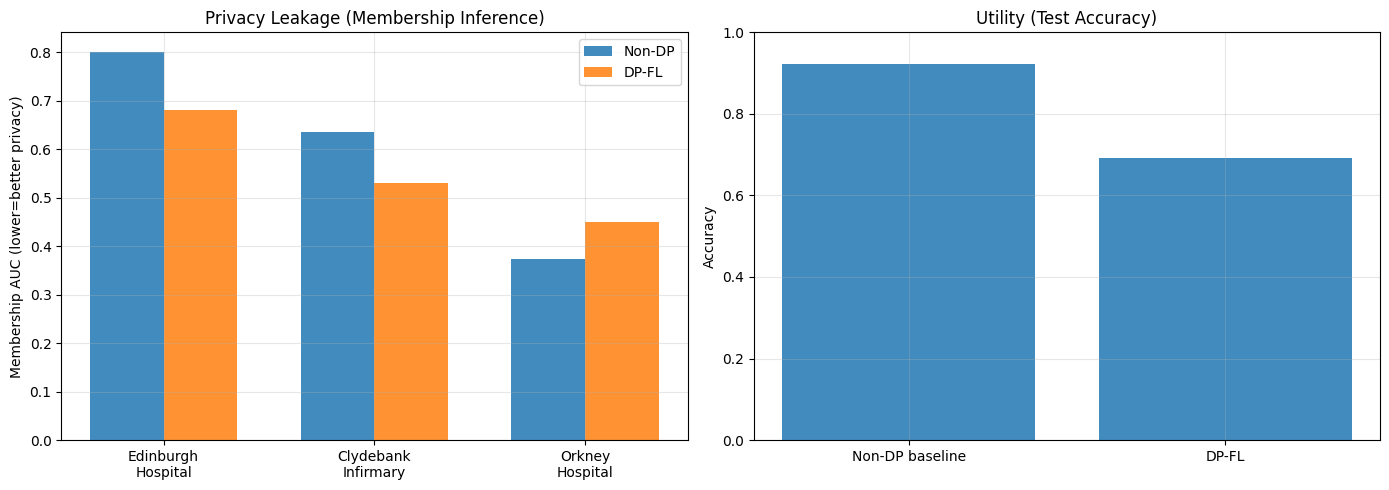

In [9]:
# Visualization: Privacy & Utility 

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# AUC bars
ax = axes[0]
names = [n for n,_ in dp_auc_by_hosp]
dp_aucs = [a for _,a in dp_auc_by_hosp]
ndp_aucs = [a for _,a in ndp_auc_by_hosp]
x = np.arange(len(names)); w = 0.35
ax.bar(x - w/2, ndp_aucs, w, label='Non-DP', alpha=0.85)
ax.bar(x + w/2, dp_aucs, w, label='DP-FL', alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels([n.replace(' ', '\n') for n in names])
ax.set_ylabel('Membership AUC (lower=better privacy)')
ax.set_title('Privacy Leakage (Membership Inference)')
ax.legend(); ax.grid(True, alpha=0.3)

# Accuracy bars
ax2 = axes[1]
ax2.bar(['Non-DP baseline','DP-FL'], [baseline_accuracy, private_accuracy], alpha=0.85)
ax2.set_ylim(0,1)
ax2.set_ylabel('Accuracy')
ax2.set_title('Utility (Test Accuracy)')
ax2.grid(True, alpha=0.3)

plt.tight_layout(); plt.show()


### Privacy budget overview

Here, ε denotes the cumulative privacy loss, depending on:
* σ (noise multiplier)
* sampling rate q (batch_size / N)
* number of steps/rounds
* δ (failure probability)

Smaller ε means a stronger privacy guarantee.

Typical guidelines:

* ε ≤ 1–3 → strong privacy
* ε ~ 5–10 → moderate
* ε > 10 → weak

In [10]:
target_budget = 5.0  # illustrative target
last_logs = dict(private_fl_server.round_logs[-1])  # {name: log}
for name in [h.hospital_name for h in private_hospitals]:
    lg = last_logs[name]
    eps = lg["epsilon_estimate"]
    remaining = max(0.0, target_budget - eps)
    print(f" {name}: ε≈{eps:.2f} after {lg['steps']} steps (σ={lg['sigma']}, q={lg['sampling_rate']:.2f})")
    print(f"   Remaining vs ε={target_budget:.1f} target: {remaining:.2f}")


 Edinburgh Hospital: ε≈2.50 after 56 steps (σ=2.5, q=0.16)
   Remaining vs ε=5.0 target: 2.50
 Clydebank Infirmary: ε≈2.53 after 56 steps (σ=2.5, q=0.16)
   Remaining vs ε=5.0 target: 2.47
 Orkney Hospital: ε≈3.86 after 32 steps (σ=2.5, q=0.31)
   Remaining vs ε=5.0 target: 1.14


## Summary

* We implemented **True DP-SGD**, which includes per-sample clipping, Gaussian noise at **each step**, and composition via a simple accountant
* **Privacy**: Membership inference AUC should approach **0.5** under stronger noise; the  **Non‑DP** model’s AUC will be higher (worse privacy).
* **Utility**: Compare DP-FL accuracy to a Non‑DP baseline; tune `sigma` (better privacy) and training rounds/hidden size (better utility).

### Exercises

##### Tuning experiment
    * Vary noise multiplier (σ) across {1.5, 2.5, 3.5}.
    * For each run, record test accuracy and ε.
    * Plot accuracy vs ε to visualize the privacy–utility tradeoff.

##### Batch size & sampling rate

   * Fix σ=2.5, but change batch fractions (q) by setting batch_size = 0.1N, 0.25N, 0.5N.
   * Measure ε and accuracy for each.

### Discussion

* How should an organisation decide what ε is acceptible?
* If tighter privacy hurts prediction accuracy, how do we set thresholds to denote when the model ceases to be clinically useful? Who should decide this threshold?
* In federated learning, some hospitals may be small (Rural) and hit their privacy budget much faster. Should they be allowed to use weaker privacy so they can contribute longer, or should all hospitals adhere to the same ε? What are the implications for equity between large and small organizations?